In [56]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn

In [57]:
# Import datasets
Mov=pd.read_csv('movies.csv',sep=',')
Rat=pd.read_csv('ratings.csv')
Osc=pd.read_csv('the_oscar_award.csv')
## Now start cleaning
# Transforming movies dataset: extract the years
def ext_movname(tlist):
    lst=tlist.copy()
    year=tlist.copy()
    for i in range(len(tlist)):
        raw=tlist[i].rstrip()
        try:
            year[i]=int(raw[-5:-1])
            lst[i]=raw[:-7]
        except:
            year[i]=np.nan
            lst[i]=raw
    return [lst,year]
u=ext_movname(Mov['title'])
Mov['title']=u[0]
Mov['year']=u[1]
CMov=Mov[Mov.year>=1994]
CMov=CMov.reset_index(drop=True)
# Function for recorrect the film name
def recorr(string):
    if '(' in string:
        nstr=string.split(' (')[0]
    else:
        nstr=string
    if ',' not in nstr:
        return nstr
    else:
        lst=nstr.split(sep=', ')
        if lst[-1] not in {'The', 'A'}:
            return nstr
        else:
            nlst=lst[:-1]
            new=lst[-1]+' '
            for j in nlst:
                new=new+j
            return new
CMov['title']=CMov['title'].apply(recorr)
# Choose the ceremony year and file name columns
C_osc=Osc[['year_ceremony','film']].dropna().copy()
C_osc=C_osc.reset_index(drop=True)
C_osc['film']=C_osc['film'].apply(recorr)
for i in range(len(C_osc)):
    if C_osc['film'][i][-1]==';':
        u=C_osc['film'][i][-1]
        C_osc['film'][i]=u[:-1]
C_osc=C_osc[C_osc.year_ceremony>=1995]
C_osc=C_osc.drop_duplicates(subset=['film'], keep='first').reset_index(drop=True)
# Combine into CMov
D_osc={C_osc['film'][i]:C_osc['year_ceremony'][i] for i in range(len(C_osc))}
lst=[]
for i in range(len(CMov['title'])):
    if CMov['title'][i] in D_osc:
        lst.append(D_osc[CMov['title'][i]])
    else:
        lst.append(0)
CMov['Oscar']=lst
cls=[int(i>0) for i in lst]
CMov['Class']=cls
ava_y=CMov['Oscar']
cmp_y=CMov['year']
for i in range(len(ava_y)):
    if ava_y[i]==0:
        ava_y[i]=cmp_y[i]+1
CMov['Oscar']=ava_y
# Transfering timestamp: extract the year data
def extract_year(time_se):
    return time.localtime(time_se).tm_year
Ye=Rat['timestamp'].apply(extract_year)
Rat['timestamp']=Ye
# Merge CMov and Rat, and filter the available rating times
R_Mov=pd.merge(CMov,Rat,on=['movieId'])
Ava_rating=R_Mov[((R_Mov.timestamp<=R_Mov.Oscar) & (R_Mov.timestamp>=R_Mov.Oscar-1))].reset_index(drop=True)[['movieId','genres','Class','rating']]
# Using groupby to get count, mean and var
g_rat=Ava_rating.groupby(by=['movieId','Class','genres'],as_index=False)
Sta_rate=g_rat.count()
Sta_rate['mean']=g_rat.mean()['rating']
Sta_rate['std']=g_rat.var()['rating'].fillna(0).apply(np.sqrt)
# Change column name
colname=list(Sta_rate.columns)
colname[3]='lg_ratetimes'
colname[4]='rate_mean'
colname[5]='rate_std'
Sta_rate.columns=colname
Sta_rate['lg_ratetimes']=Sta_rate['lg_ratetimes'].apply(np.log)

/Users/lihuayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
# Adding 9 genre columns
Sp=Sta_rate.shape
Hot_mat=np.array([0]*Sp[0]*9)
Hot_mat.shape=(Sp[0],9)
Hot_mat
for i in range(Sp[0]):
    gen=Sta_rate['genres'][i].split(sep='|')
    if 'Action' in gen:
        Hot_mat[i,0]=1
    if 'Adventure' in gen:
        Hot_mat[i,1]=1
    if 'Comedy' in gen:
        Hot_mat[i,2]=1
    if 'Crime' in gen:
        Hot_mat[i,3]=1
    if 'Drama' in gen:
        Hot_mat[i,4]=1
    if 'Fantasy' in gen:
        Hot_mat[i,5]=1
    if 'Romance' in gen:
        Hot_mat[i,6]=1
    if 'Sci-Fi' in gen:
        Hot_mat[i,7]=1
    if 'Thriller' in gen:
        Hot_mat[i,8]=1
Sta_rate['is_Action']=Hot_mat[:,0]
Sta_rate['is_Adventure']=Hot_mat[:,1]
Sta_rate['is_Comedy']=Hot_mat[:,2]
Sta_rate['is_Crime']=Hot_mat[:,3]
Sta_rate['is_Drama']=Hot_mat[:,4]
Sta_rate['is_Fantasy']=Hot_mat[:,5]
Sta_rate['is_Romance']=Hot_mat[:,6]
Sta_rate['is_Sci_Fi']=Hot_mat[:,7]
Sta_rate['is_Thriller']=Hot_mat[:,8]

In [60]:
Sta_rate=Sta_rate.drop(['genres'],axis=1)

In [61]:
Sta_rate

,movieId,Class,lg_ratetimes,rate_mean,rate_std,is_Action,is_Adventure,is_Comedy,is_Crime,is_Drama,is_Fantasy,is_Romance,is_Sci_Fi,is_Thriller
0,1,1,9.051345,4.119812,0.887872,0,1,1,0,0,1,0,0,0
1,2,0,8.839277,3.574058,0.885957,0,1,0,0,0,1,0,0,0
2,3,0,8.103494,3.424380,0.957745,0,0,1,0,0,0,1,0,0
3,4,0,7.218177,3.049120,1.117364,0,0,1,0,1,0,1,0,0
4,5,0,8.327968,3.345094,0.916268,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15052,193863,0,0.000000,2.000000,0.000000,0,0,0,0,1,0,0,0,0
15053,193866,0,0.000000,1.000000,0.000000,0,0,0,0,0,0,0,0,0
15054,193872,0,0.000000,4.000000,0.000000,0,0,0,0,1,0,0,0,0
15055,193882,0,0.000000,2.000000,0.000000,0,1,0,0,1,0,0,1,0


In [62]:
# Finally, apply logistic regression
Y=Sta_rate['Class']
X=Sta_rate.drop(['movieId','Class'],axis=1)
# Random shuffle, and split dataset
np.random.seed(625)
rp=np.random.permutation(len(Y))
X_train=X.iloc[rp[2000:]]
X_test=X.iloc[rp[:2000]]
Y_train=Y.iloc[rp[2000:]]
Y_test=Y.iloc[rp[:2000]]
# Model fitting
clf=LogisticRegression(class_weight='balanced').fit(X_train,Y_train)

In [63]:
# Model coefficients
expr='logit(p)='+str(round(clf.intercept_[0],4))+'+'+str(round(clf.coef_[0][0],4))+'log(rate_times)'+'+'+str(round(clf.coef_[0][1],4))+'rate_mean'+'+'+str(round(clf.coef_[0][2],4))+'rate_std'
gen=list(Sta_rate.columns[5:])
for i in range(9):
    part='+'+str(round(clf.coef_[0][(i+3)],4))+gen[i]
    expr+=part
print(expr)
# This means the model is logit(p)=-5.5623+0.6432log(rate_times)+1.0731rate_mean+-0.6081rate_std+-0.5568is_Action+0.6382is_Adventure+-1.113is_Comedy+-0.3586is_Crime+0.2803is_Drama+-0.0304is_Fantasy
# +-0.0139is_Romance+-0.7384is_Sci_Fi+-0.8735is_Thriller

logit(p)=-5.5623+0.6432log(rate_times)+1.0731rate_mean+-0.6081rate_std+-0.5568is_Action+0.6382is_Adventure+-1.113is_Comedy+-0.3586is_Crime+0.2803is_Drama+-0.0304is_Fantasy+-0.0139is_Romance+-0.7384is_Sci_Fi+-0.8735is_Thriller


In [64]:
# Now using upon testing dataset
# Fitting score
clf.score(X_test,Y_test)

0.806

In [65]:
# Or:
err=np.mean(clf.predict(X_test)!=Y_test)
print('The test error is:  %.2f%%' % (err*100))

The test error is:  19.40%


In [66]:
# Try statsmodels.api for Statistical Inference
import statsmodels.api as sm
import statsmodels.formula.api as smf
# First of all, get the frequency weight, which is the same as that in 
# LogisticRegression(class_weight='balanced')
np.random.seed(625)
rp=np.random.permutation(len(Y))
Train=Sta_rate.iloc[rp[2000:]]
Test=Sta_rate.iloc[rp[:2000]]
W=Train.groupby('Class').count()['movieId']
Train['weight']=(W[1]+(W[0]-W[1])*Train['Class'])/W[1]

/Users/lihuayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [67]:
# Using logistic regression.
expr='Class~lg_ratetimes+rate_mean+rate_std'
for i in range(9):
    part='+'+gen[i]
    expr+=part
glm=smf.glm(expr,data=Train,
            family=sm.families.Binomial(),
           freq_weights=Train['weight'])
clf2=glm.fit()

In [68]:
# First of all, the summary
clf2.summary()
# According to the result, all of the parameter tests are remarkable.
# And the results in the two models are really close.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Class   No. Observations:                13057
Model:                            GLM   Df Residuals:                    24435
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10291.
Date:                Sat, 19 Sep 2020   Deviance:                       20582.
Time:                        20:02:21   Pearson chi2:                 3.32e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.5622      0.167    -33.283      0.000      -5.890      -5.235
lg_ratetimes     0.6443      0.010     62.852      0.000       0.624       0.664
rate_mean        1.0739      0.041     26.235      0.000       0.994       1.154
rate_std        -0.6128      0.066     -9.257      0.000      -0.743      -0.483
is_Action       -0.5599      0.061     -9.145      0.000      -0.680      -0.440
is_Adventure     0.6448      0.065      9.880      0.000       0.517       0.773
is_Comedy       -1.1191      0.045    -24.873      0.000      -1.207      -1.031
is_Crime        -0.3606      0.064     -5.672      0.000      -0.485      -0.236
is_Drama         0.2797      0.038      7.360      0.000       0.205       0.354
is_Fantasy      -0.0326      0.078     -0.417      0.677      -0.186       0.121
is_Romance      -0.0137      0.051     -0.267      0.790      -0.114       0.087
is_Sci_Fi       -0.7471      0.079     -9.496      0.000      -0.901      -0.593
is_Thriller     -0.8781      0.054    -16.243      0.000      -0.984      -0.772
================================================================================
"""

In [69]:
# This predicting error
pred=clf2.predict(X_test)
err2=np.mean((pred>0.5)!=Y_test)
print('The test error is:  %.2f%%' % (err2*100))

The test error is:  19.40%


In [70]:
# Finally we focus on the error upon different classes
# Using LogisticRegression in scikit:
# The Oscar class(label 1)
C1=clf.predict(X_test[Y_test==1])
err_c1=np.mean(C1!=1)
print('The test error in class 1 is:  %.2f%%' % (err_c1*100))
# The Non-Oscar class(label 0)
C2=clf.predict(X_test[Y_test==0])
err_c2=np.mean(C2!=0)
print('The test error in class 0 is:  %.2f%%' % (err_c2*100))

The test error in class 1 is:  17.61%
The test error in class 0 is:  19.54%


In [71]:
# Using glm in statsmodels:
# The Oscar class(label 1)
C1_s=clf2.predict(X_test[Y_test==1])
err_c1s=np.mean((C1_s>=0.5)!=1)
print('The test error in class 1 is:  %.2f%%' % (err_c1s*100))
# The Non-Oscar class(label 0)
C2_s=clf2.predict(X_test[Y_test==0])
err_c2s=np.mean((C2_s<0.5)!=1)
print('The test error in class 0 is:  %.2f%%' % (err_c2s*100))

The test error in class 1 is:  17.61%
The test error in class 0 is:  19.54%


In [72]:
## Or: consider confusion matrix
from sklearn.metrics import confusion_matrix
M1=confusion_matrix(Y_test,clf.predict(X_test))

In [73]:
M2=confusion_matrix(Y_test,clf2.predict(X_test)>0.5)

In [74]:
# Add: Correlation matrix of the three parameters

Text(0.5, 1, 'Heatmap of the correlation matrix upon total data')

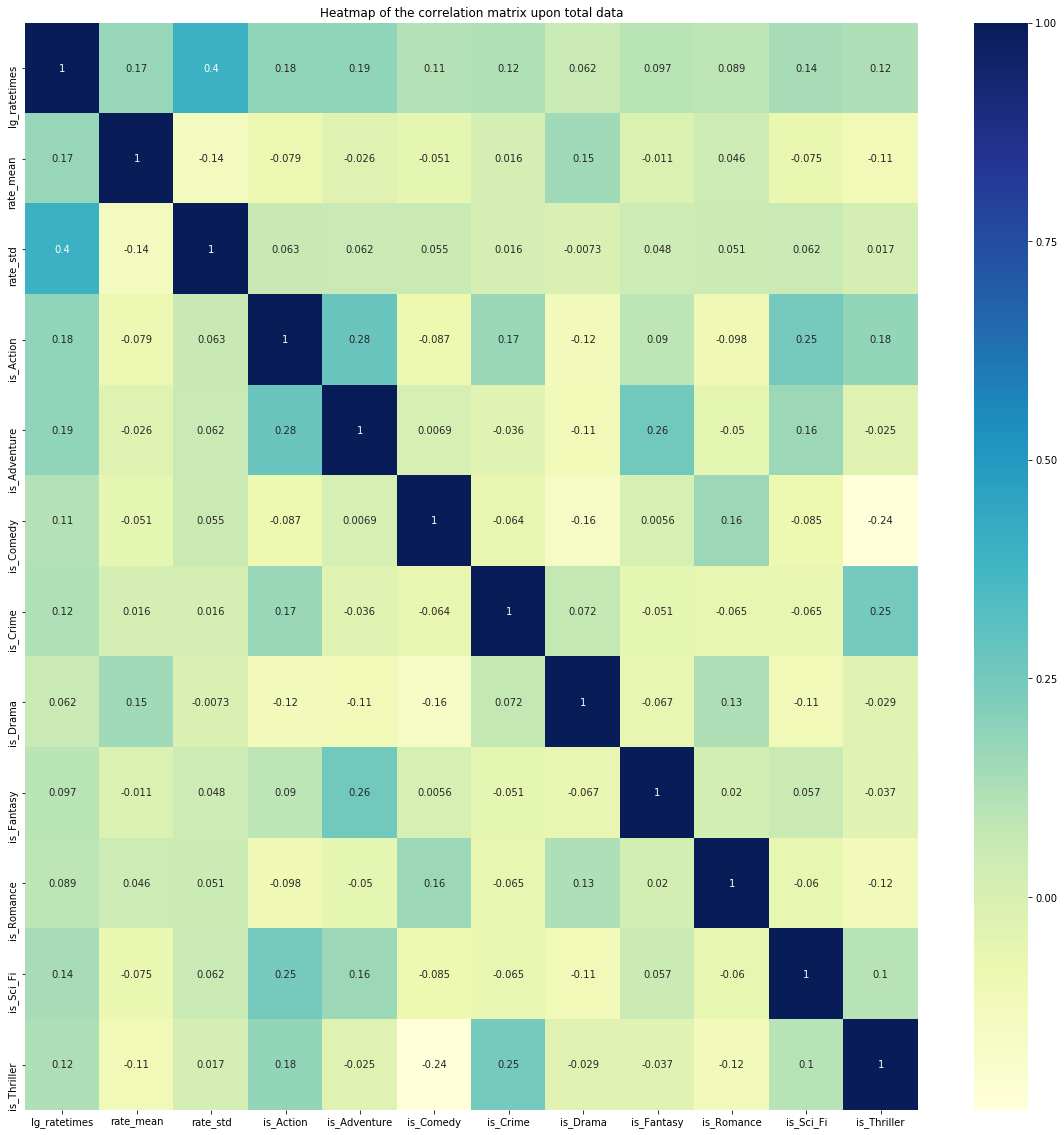

In [80]:
import seaborn as sn
Cor_total=np.corrcoef(X,rowvar=0)
fig,ax=plt.subplots(figsize=(20,20))
sn.heatmap(Cor_total,annot=True,cmap="YlGnBu")
ax.set_xticklabels(list(X.columns))
ax.set_yticklabels(list(X.columns))
ax.set_title('Heatmap of the correlation matrix upon total data')

Text(0.5, 1, 'Heatmap of the correlation matrix upon training data')

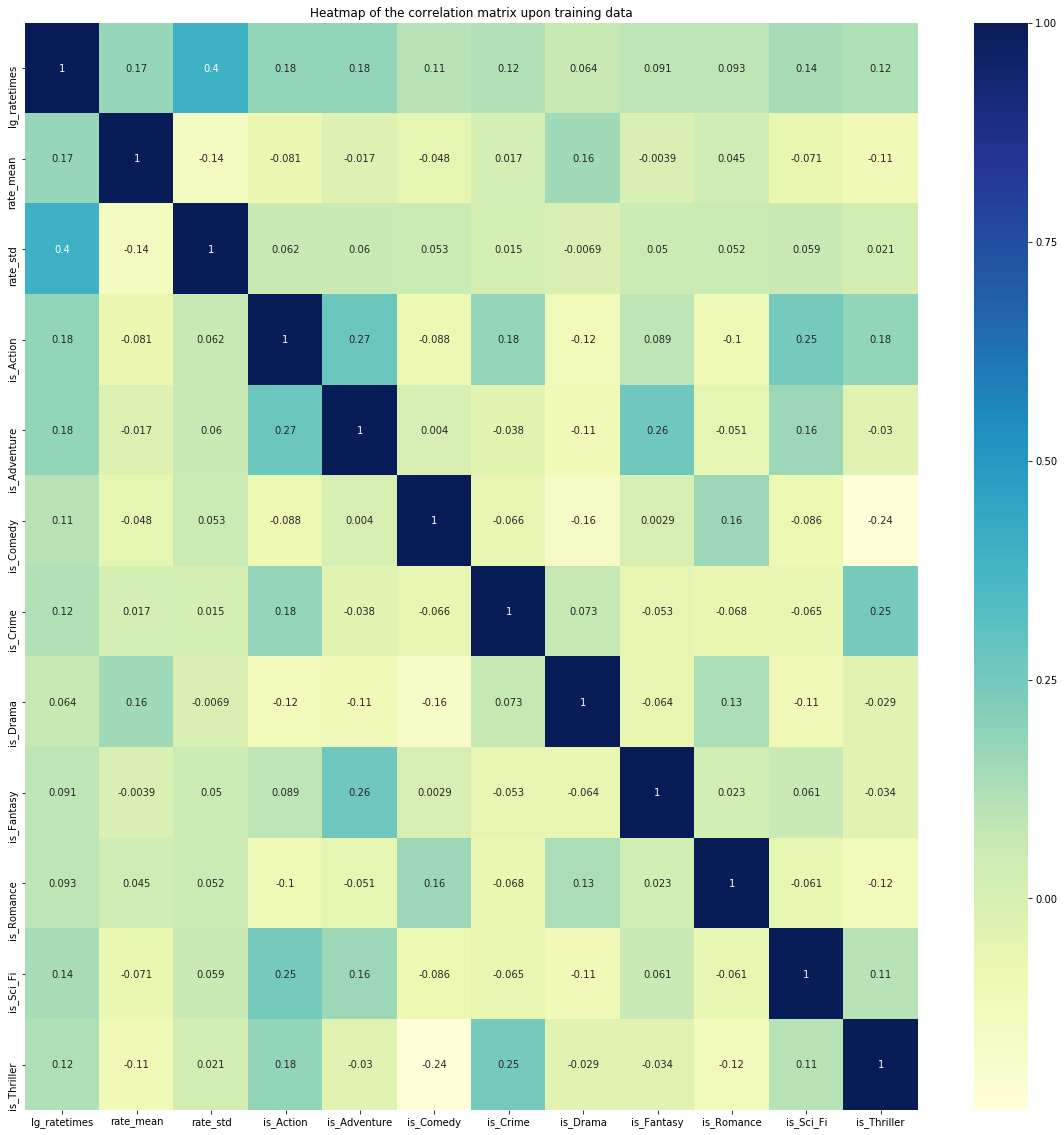

In [81]:
Cor_train=np.corrcoef(X_train,rowvar=0)
fig,ax=plt.subplots(figsize=(20,20))
sn.heatmap(Cor_train,annot=True,cmap="YlGnBu")
ax.set_xticklabels(list(X_train.columns))
ax.set_yticklabels(list(X_train.columns))
ax.set_title('Heatmap of the correlation matrix upon training data')

Text(0.5, 1, 'Heatmap of the correlation matrix upon testing data')

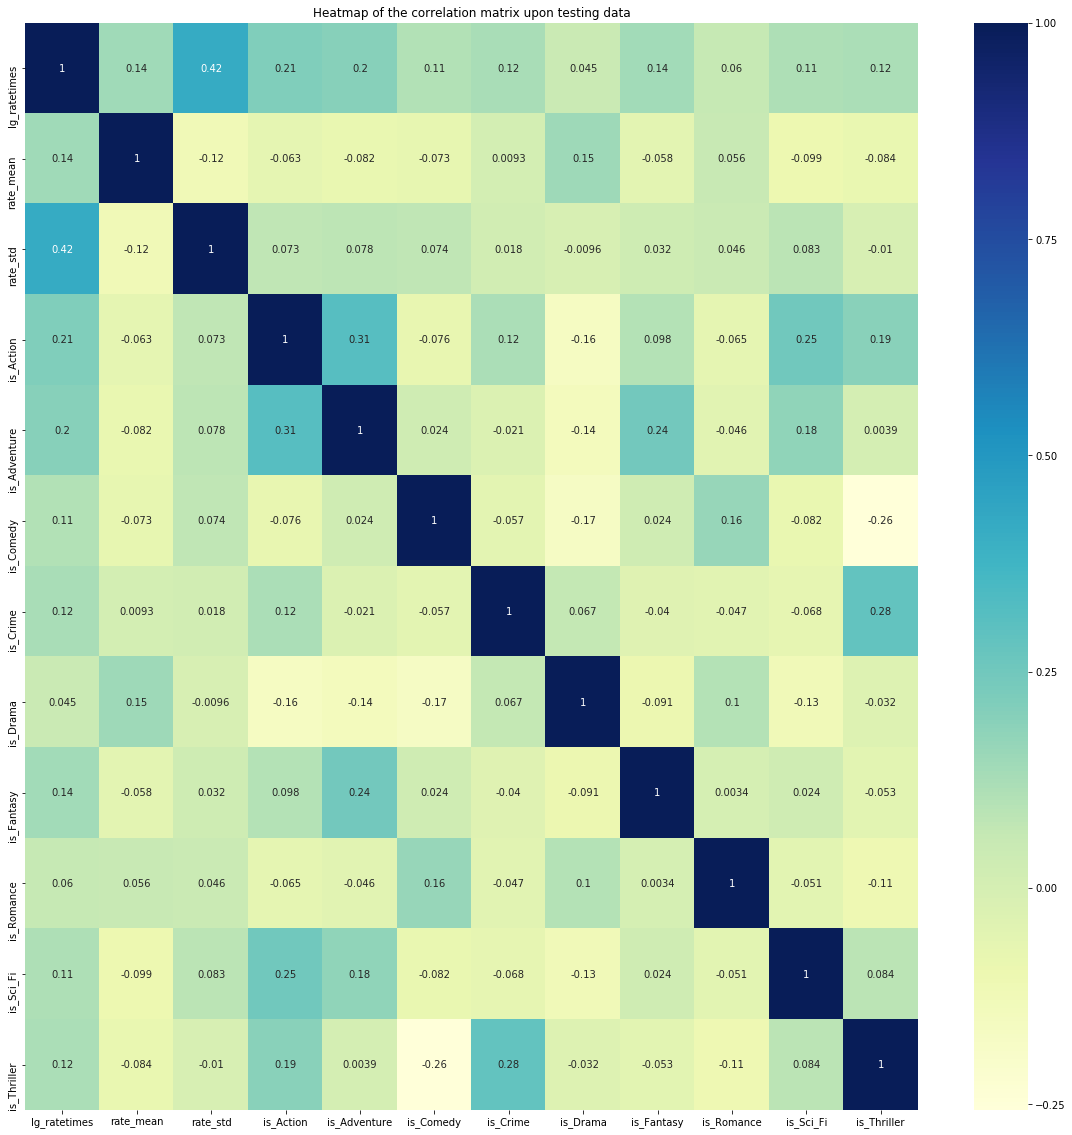

In [82]:
Cor_test=np.corrcoef(X_test,rowvar=0)
fig,ax=plt.subplots(figsize=(20,20))
sn.heatmap(Cor_test,annot=True,cmap="YlGnBu")
ax.set_xticklabels(list(X_test.columns))
ax.set_yticklabels(list(X_test.columns))
ax.set_title('Heatmap of the correlation matrix upon testing data')